In [86]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import os
import json
from sklearn.cross_validation import train_test_split
from nltk.corpus import stopwords
import time
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.6.0


In [87]:
file_path = os.getcwd()+"/idebateextra.json"
Glove_path=os.getcwd()+"/glove.6B.50d.txt"

def load_data(file_path):
    with open(file_path) as file:
        raw_data=file.read()
        json_data=json.loads(raw_data)
    dataframe=pd.DataFrame(columns=["text","summary"])
    for i in json_data:
        text_summary_pair={}
        text=" "
        for x in i["_argument_sentences"]:
            text=text+i["_argument_sentences"][x].lower()
            #probably we can get rid of stopping word and punctuaton for input
        text_summary_pair["text"]=text
        text_summary_pair["summary"]=i["_claim"]
        dataframe=dataframe.append(text_summary_pair,ignore_index=True)#append doesn't happen in place
    return dataframe
##########################################
dataframe=load_data(file_path)

In [88]:
train_dataframe.head()

,text,summary
4348,,It is a power that state governors already have
3494,imperialism and colonisation is one of the gr...,Ethnic borders erase a wrong of history
2050,an amnesty by its very definition is letting ...,An amnesty rewards law breakers
1172,"in response to an ever faster news agenda , p...","In an age of declining journalistic standards,..."
288,what is needed for the eurozone to flourish i...,Political union is necessary for Eurozone reco...


In [89]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
##################################################
embeddings_index=loadGloveModel(Glove_path)

Loading Glove Model
Done. 400000  words loaded!


In [90]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [91]:
word_counts = {}
count_words(word_counts, dataframe["text"])
count_words(word_counts, dataframe["summary"])
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 38819


In [92]:
missing_words = 0
threshold = 2

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from glove:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from glove: 1746
Percent of words that are missing from vocabulary: 4.5%


In [93]:
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

Total number of unique words: 38819
Number of words we will use: 30800
Percent of words we will use: 79.34%


In [94]:
embedding_dim = 50
nb_words = len(vocab_to_int)

# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim), dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

30800


In [95]:
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [96]:
clean_summaries=dataframe["summary"]
clean_texts=dataframe["text"]

In [97]:
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(clean_summaries, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(clean_texts, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 964675
Total number of UNKs in headlines: 8023
Percent of words that are UNK: 0.83%


In [99]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

Summaries:
            counts
count  4351.000000
mean      9.891979
std       5.821625
min       1.000000
25%       6.000000
50%       9.000000
75%      12.000000
max      47.000000

Texts:
            counts
count  4351.000000
mean    212.821420
std     105.603906
min       1.000000
25%     143.000000
50%     192.000000
75%     256.000000
max    1207.000000


In [100]:
print(np.percentile(lengths_texts.counts, 90))
print(np.percentile(lengths_texts.counts, 95))
print(np.percentile(lengths_texts.counts, 99))

333.0
400.0
592.0


In [101]:
print(np.percentile(lengths_summaries.counts, 90))
print(np.percentile(lengths_summaries.counts, 95))
print(np.percentile(lengths_summaries.counts, 99))

17.0
21.0
30.0


In [102]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [103]:
sorted_summaries = []
sorted_texts = []
max_text_length = 400
max_summary_length = 30
min_length = 2
unk_text_limit = 30
unk_summary_limit = 5

for length in range(min(lengths_texts.counts), max_text_length): 
    for count, words in enumerate(int_summaries):
        if (len(int_summaries[count]) >= min_length and
            len(int_summaries[count]) <= max_summary_length and
            len(int_texts[count]) >= min_length and
            unk_counter(int_summaries[count]) <= unk_summary_limit and
            unk_counter(int_texts[count]) <= unk_text_limit and
            length == len(int_texts[count])
           ):
            sorted_summaries.append(int_summaries[count])
            sorted_texts.append(int_texts[count])
        
# Compare lengths to ensure they match
print(len(sorted_summaries))
print(len(sorted_texts))

4049
4049


In [104]:
def model_inputs():
    '''Create palceholders for inputs to the model'''
    
    input_data = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    summary_length = tf.placeholder(tf.int32, (None,), name='summary_length')
    max_summary_length = tf.reduce_max(summary_length, name='max_dec_len')
    text_length = tf.placeholder(tf.int32, (None,), name='text_length')

    return input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length

In [105]:
def process_encoding_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    dec_input = tf.concat([tf.fill([batch_size, 1], vocab_to_int['<GO>']), ending], 1)

    return dec_input

In [106]:
def encoding_layer(rnn_size, sequence_length, num_layers, rnn_inputs, keep_prob):
    '''Create the encoding layer'''
    
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer)):
            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, 
                                                    input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size,
                                              initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, 
                                                    input_keep_prob = keep_prob)

            enc_output, enc_state = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                                    cell_bw, 
                                                                    rnn_inputs,
                                                                    sequence_length,
                                                                    dtype=tf.float32)
    # Join outputs since we are using a bidirectional RNN
    enc_output = tf.concat(enc_output,2)
    
    return enc_output, enc_state

In [107]:
def training_decoding_layer(dec_embed_input, summary_length, dec_cell, initial_state, output_layer, 
                            vocab_size, max_summary_length):
    '''Create the training logits'''
    
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs=dec_embed_input,
                                                        sequence_length=summary_length,
                                                        time_major=False)

    training_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                       training_helper,
                                                       initial_state,
                                                       output_layer) 

    training_logits, _,_ = tf.contrib.seq2seq.dynamic_decode(training_decoder,
                                                           output_time_major=False,
                                                           impute_finished=True,
                                                           maximum_iterations=max_summary_length)
    return training_logits

In [108]:
def inference_decoding_layer(embeddings, start_token, end_token, dec_cell, initial_state, output_layer,
                             max_summary_length, batch_size):
    '''Create the inference logits'''
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    
    inference_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(embeddings,
                                                                start_tokens,
                                                                end_token)
                
    inference_decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell,
                                                        inference_helper,
                                                        initial_state,
                                                        output_layer)
                
    inference_logits, _ ,_= tf.contrib.seq2seq.dynamic_decode(inference_decoder,
                                                            output_time_major=False,
                                                            impute_finished=True,
                                                            maximum_iterations=max_summary_length)
    
    return inference_logits

In [109]:
def decoding_layer(dec_embed_input, embeddings, enc_output, enc_state, vocab_size, text_length, summary_length, 
                   max_summary_length, rnn_size, vocab_to_int, keep_prob, batch_size, num_layers):
    '''Create the decoding cell and attention for the training and inference decoding layers'''
    
    for layer in range(num_layers):
        with tf.variable_scope('decoder_{}'.format(layer)):
            lstm = tf.contrib.rnn.LSTMCell(rnn_size,
                                           initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
            dec_cell = tf.contrib.rnn.DropoutWrapper(lstm, 
                                                     input_keep_prob = keep_prob)
    
    output_layer = Dense(vocab_size,
                         kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    attn_mech = tf.contrib.seq2seq.BahdanauAttention(rnn_size,
                                                  enc_output,
                                                  text_length,
                                                  normalize=False,
                                                  name='BahdanauAttention')

    dec_cell = tf.contrib.seq2seq.AttentionWrapper(dec_cell,
                                                   attn_mech,
                                                   rnn_size)
            
    
    initial_state = dec_cell.zero_state(dtype=tf.float32, batch_size=batch_size)
    initial_state = initial_state.clone(cell_state=enc_state[0])
    with tf.variable_scope("decode"):
        training_logits = training_decoding_layer(dec_embed_input, 
                                                  summary_length, 
                                                  dec_cell, 
                                                  initial_state,
                                                  output_layer,
                                                  vocab_size, 
                                                  max_summary_length)
    with tf.variable_scope("decode", reuse=True):
        inference_logits = inference_decoding_layer(embeddings,  
                                                    vocab_to_int['<GO>'], 
                                                    vocab_to_int['<EOS>'],
                                                    dec_cell, 
                                                    initial_state, 
                                                    output_layer,
                                                    max_summary_length,
                                                    batch_size)

    return training_logits, inference_logits

In [110]:
def seq2seq_model(input_data, target_data, keep_prob, text_length, summary_length, max_summary_length, 
                  vocab_size, rnn_size, num_layers, vocab_to_int, batch_size):
    '''Use the previous functions to create the training and inference logits'''
    
    # Use Numberbatch's embeddings and the newly created ones as our embeddings
    embeddings = word_embedding_matrix
    
    enc_embed_input = tf.nn.embedding_lookup(embeddings, input_data)
    enc_output, enc_state = encoding_layer(rnn_size, text_length, num_layers, enc_embed_input, keep_prob)
    
    dec_input = process_encoding_input(target_data, vocab_to_int, batch_size)
    dec_embed_input = tf.nn.embedding_lookup(embeddings, dec_input)
    
    training_logits, inference_logits  = decoding_layer(dec_embed_input, 
                                                        embeddings,
                                                        enc_output,
                                                        enc_state, 
                                                        vocab_size, 
                                                        text_length, 
                                                        summary_length, 
                                                        max_summary_length,
                                                        rnn_size, 
                                                        vocab_to_int, 
                                                        keep_prob, 
                                                        batch_size,
                                                        num_layers)
    
    return training_logits, inference_logits

In [111]:
def pad_sentence_batch(sentence_batch):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [vocab_to_int['<PAD>']] * (max_sentence - len(sentence)) for sentence in sentence_batch]

In [112]:
def get_batches(summaries, texts, batch_size):
    """Batch summaries, texts, and the lengths of their sentences together"""
    for batch_i in range(0, len(texts)//batch_size):
        start_i = batch_i * batch_size
        summaries_batch = summaries[start_i:start_i + batch_size]
        texts_batch = texts[start_i:start_i + batch_size]
        pad_summaries_batch = np.array(pad_sentence_batch(summaries_batch))
        pad_texts_batch = np.array(pad_sentence_batch(texts_batch))
        
        # Need the lengths for the _lengths parameters
        pad_summaries_lengths = []
        for summary in pad_summaries_batch:
            pad_summaries_lengths.append(len(summary))
        
        pad_texts_lengths = []
        for text in pad_texts_batch:
            pad_texts_lengths.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lengths, pad_texts_lengths

In [129]:
# Set the Hyperparameters
epochs = 30
batch_size = 64
rnn_size = 256
num_layers = 1
learning_rate = 0.01
keep_probability = 0.8

In [130]:
train_graph = tf.Graph()
# Set the graph to default to ensure that it is ready for training
with train_graph.as_default():
    
    # Load the model inputs    
    input_data, targets, lr, keep_prob, summary_length, max_summary_length, text_length = model_inputs()

    # Create the training and inference logits
    training_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                      targets, 
                                                      keep_prob,   
                                                      text_length,
                                                      summary_length,
                                                      max_summary_length,
                                                      len(vocab_to_int)+1,
                                                      rnn_size, 
                                                      num_layers, 
                                                      vocab_to_int,
                                                      batch_size)
    
    # Create tensors for the training logits and inference logits
    training_logits = tf.identity(training_logits.rnn_output, 'logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')
    
    # Create the weights for sequence_loss
    masks = tf.sequence_mask(summary_length, max_summary_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)
print("Graph is built.")

Graph is built.


In [132]:
learning_rate_decay = 0.95
min_learning_rate = 0.0001
display_step = 2 # Check training loss after every 20 batches
stop_early = 0 
stop = 3 # If the update loss does not decrease in 3 consecutive update checks, stop training
per_epoch = 3 # Make 3 update checks per epoch
update_check = (len(sorted_texts)//batch_size//per_epoch)-1


update_loss = 0 
batch_loss = 0
summary_update_loss = [] # Record the update losses for saving improvements in the model
loss_list_bi_withatt=[]
checkpoint = "./idebate_with_attention_singlelayer.ckpt" 
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    # If we want to continue training a previous session
    #loader = tf.train.import_meta_graph(checkpoint + '.meta')
    #loader.restore(sess, checkpoint)
    
    for epoch_i in range(1, epochs+1):
        update_loss = 0
        batch_loss = 0
        for batch_i, (summaries_batch, texts_batch, summaries_lengths, texts_lengths) in enumerate(
                get_batches(sorted_summaries, sorted_texts, batch_size)):
            start_time = time.time()
            _, loss = sess.run(
                [train_op, cost],
                {input_data: texts_batch,
                 targets: summaries_batch,
                 lr: learning_rate,
                 summary_length: summaries_lengths,
                 text_length: texts_lengths,
                 keep_prob: keep_probability})

            batch_loss += loss
            update_loss += loss
            end_time = time.time()
            batch_time = end_time - start_time

            if batch_i % display_step == 0 and batch_i > 0:
                loss_list_bi_withatt.append(batch_loss / display_step)
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}, Seconds: {:>4.2f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(sorted_texts) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                batch_loss = 0

            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss for this update:", round(update_loss/update_check,3))
                summary_update_loss.append(update_loss)
                
                # If the update loss is at a new minimum, save the model
                if update_loss <= min(summary_update_loss):
                    print('New Record!') 
                    stop_early = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    stop_early += 1
                    if stop_early == stop:
                        break
                update_loss = 0
            
                    
        # Reduce learning rate, but not below its minimum value
        learning_rate *= learning_rate_decay
        if learning_rate < min_learning_rate:
            learning_rate = min_learning_rate
        
        if stop_early == stop:
            print("Stopping Training.")
            break

Epoch   1/30 Batch    2/63 - Loss: 17.006, Seconds: 6.66
Epoch   1/30 Batch    4/63 - Loss:  7.214, Seconds: 7.48
Epoch   1/30 Batch    6/63 - Loss:  5.672, Seconds: 8.41
Epoch   1/30 Batch    8/63 - Loss:  3.857, Seconds: 8.17
Epoch   1/30 Batch   10/63 - Loss:  3.225, Seconds: 6.93
Epoch   1/30 Batch   12/63 - Loss:  2.913, Seconds: 8.58
Epoch   1/30 Batch   14/63 - Loss:  3.651, Seconds: 6.62
Epoch   1/30 Batch   16/63 - Loss:  3.405, Seconds: 6.93
Epoch   1/30 Batch   18/63 - Loss:  2.783, Seconds: 9.92
Epoch   1/30 Batch   20/63 - Loss:  2.795, Seconds: 9.15
Average loss for this update: 5.252
New Record!


InvalidArgumentError: NodeDef expected inputs 'int32, int32' do not match 0 inputs specified; Op<name=Max; signature=input:T, reduction_indices:Tidx -> output:T; attr=keep_dims:bool,default=false; attr=T:type,allowed=[DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, ..., DT_UINT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]; attr=Tidx:type,default=DT_INT32,allowed=[DT_INT32, DT_INT64]>; NodeDef: max_dec_len_1 = Max[T=DT_INT32, Tidx=DT_INT32, _output_shapes=[[]], keep_dims=false]()

In [ ]:
def text_to_seq(text):
    '''Prepare the text for the model'''
    return [vocab_to_int.get(word, vocab_to_int['<UNK>']) for word in text.split()]

In [ ]:
random = np.random.randint(0,len(clean_texts))
input_sentence = clean_texts[random]
expected_summary=clean_summaries[random]
text = text_to_seq(clean_texts[random])

checkpoint = "./idebate_with_attention_singlelayer.ckpt"

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(checkpoint + '.meta')
    loader.restore(sess, checkpoint)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    text_length = loaded_graph.get_tensor_by_name('text_length:0')
    summary_length = loaded_graph.get_tensor_by_name('summary_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    #Multiply by batch_size to match the model's input parameters
    answer_logits = sess.run(logits, {input_data: [text]*batch_size, 
                                      summary_length: [np.random.randint(5,8)], 
                                      text_length: [len(text)]*batch_size,
                                      keep_prob: 1.0})[0] 

# Remove the padding from the tweet
pad = vocab_to_int["<PAD>"] 

print('\nText')
#print('  Word Ids:    {}'.format([i for i in text]))
print(" "+" ".join([int_to_vocab[i] for i in text]))
print('\nExpected Summary:')
print(" "+expected_summary)

print('\nPredicted Summary:')
#print('  Word Ids:       {}'.format([i for i in answer_logits if i != pad]))
print(" "+" ".join([int_to_vocab[i] for i in answer_logits if i != pad]))

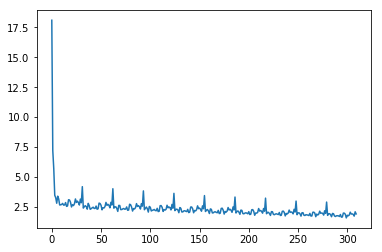

In [128]:
import matplotlib.pyplot as plt
plt.plot(loss_list_bi_withatt)

In [53]:
x

[]